#### This project is from [Abubakar Abid's](https://twitter.com/abidlabs) course: *Building Computer Vision Applications* on CoRise. Learn more about the course [here](https://corise.com/course/vision-applications).

# Week 3 Project: Building a Facial Identity Recognition System

Welcome to the third week's project for *Building Computer Vision Applications*!

In this week, we are going to get familiar with the key steps of machine learning, with a particular focus on image embedding. Specifically, we will cover:

* finding pretrained image embedding models and using them on our own data 👾
* building an image dataset and uploading it to the Hugging Face Hub 📖
* measuring the performance of an image embedding model on test data and the real world 📈
* building a facial identity recognition app you can run on your phone or laptop 📷


# Introduction

[Face ID](https://en.wikipedia.org/wiki/Face_ID) was introduced by Apple in 2017 as an alternative to fingerprint-based authentication for iPhones. The way that Face ID works is that it uses infrared projectors that shine around 30,000 infrared dots onto a user's face. Then an infrared camera reads the reflections to come up with an infrared "image" of a person's face. Using neural networks, Face ID predicts if the recorded infrared image is similar enough to a stored profile, in which case the phone unlocks.

In this project, we will recreate the last part of this process -- building an application that can recognize if two faces belong to the same person, based on optical pictures (i.e. regular images, not infrared images) of their face. This is quite a difficult problem because it requires us to simultaneously perform two tasks: (1) tell two people (who may look quite similar) apart (2) recognize that two photos of the same person (potentially taken in very different lighting, clothing, or other conditions) are of the same person. In order to do this project, we will use models for *image embedding*, which can convert any image to a numerical vector called an embedding. These embeddings can be used to compare images more easily, as computing distances between different embeddings can be a meaningful signal of how similar the respective images are.

By the end of this project, you'll have built an app that takes in two pictures from your webcam and will predict whether they are the same person or not. This can form the basis of facial identity recognition software. It will look something like this:

![](https://i.ibb.co/T0cDVLs/image.png)

# Step 0: Hardware Setup & Software Libraries

We will be utilizing GPUs to train our machine learning model, so we will need to make sure that our colab notebook is set up correctly. Go to the menu bar and click on Runtime > Change runtime type > Hardware accelerator and **make sure it is set to GPU**. Your colab notebook may restart once you make the change.

We're going to be using some fantastic open-source Python libraries to upload our dataset (`datasets`), load our model (`sentence-transformers`), evaluate our model (`scikit-learn`), and build a demo of our model (`gradio`). So let's go ahead and install all of these libraries.

In [ ]:
%%capture
!pip install datasets huggingface_hub sentence-transformers gradio

In Week 2, you uploaded a model to your Hugging Face account programmatically. This week, you'll be uploading a dataset! The first step is to log in using your Hugging Face token:

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

# Step 1: Loading Pretrained Image Embedding Models

In this project, we will be loading several pretrained image embedding models and comparing their performance. In particular, we will compare:

* https://huggingface.co/sentence-transformers/clip-ViT-B-16
* https://huggingface.co/sentence-transformers/clip-ViT-B-32
* https://huggingface.co/sentence-transformers/clip-ViT-L-14

* **1a. Compare the models**

When considering which machine learning model to use for a particular task, there are several things to consider:
* The metrics that are relevant to you
* The size of the model
* The inference time of the model

Which of these models has the best reported performance on the model card?
Which has the worst reported performance? [ANSWER HERE]
<br> Ans:

| Model         | Top 1 Performance |
|---------------|-------------------|
| clip-ViT-B-32 | 63.3              |
| clip-ViT-B-16 | 68.1              |
| clip-ViT-L-14 | 75.4              |

`clip-ViT-L-14` has the best performance and `clip-ViT-B-32` has the worst performance.


What task was the performance reported on? What does this task mean? [ANSWER HERE]

The performance is reported on a zero-shot task

Which of these models has the the largest size on disk? Which is the smallest? *Hint*: look for the PyTorch binary file. [ANSWER HERE]


What model do you expect to run the fastest? The slowest? [ANSWER HERE]



* **1b. Load one of the models**

Pick one of the models above and load it using the [Sentence Transformers](https://www.sbert.net/) library.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/clip-ViT-L-14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


* **1c. Use the model to embed a few photos with faces**

The following code downloads and displays 3 images from the web. We will use the `SentenceTransformer` you downloaded above to embed these images.

In [ ]:
from PIL import Image
from io import BytesIO
import requests

urls = {
    "https://live.staticflickr.com/5551/14616229927_7ed70f7836_b.jpg": "Robert Downey Jr",
    "https://live.staticflickr.com/3849/14800476884_6dbda11c8c_b.jpg": "Robert Downey Jr",
    "https://live.staticflickr.com/8187/8138909428_2d9e94332a.jpg": "Gwyneth Paltrow"
}

image_list = []

for index, (url, label) in enumerate(urls.items()):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  image_list.append(img)
  print(label)
  display(img)

Output hidden; open in https://colab.research.google.com to view.

Use the `SentenceTransformer` model to embed these images.

In [ ]:
image_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7F16BB75E140>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7F17B1B451B0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=405x480 at 0x7F17857CA380>]

In [ ]:
# Encode an image
img_emb = model.encode([image for image in image_list], convert_to_tensor=True, show_progress_bar=True).cpu()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

* **1d. Explore the embeddings**

* What are the dimensions of the images we downloaded?

In [ ]:
# ANSWER HERE
print(f"Dimensions of image 1 -> {image_list[0].size}")
print(f"Dimensions of image 2 -> {image_list[1].size}")
print(f"Dimensions of image 3 -> {image_list[2].size}")

Dimensions of image 1 -> (1024, 683)
Dimensions of image 2 -> (1024, 683)
Dimensions of image 3 -> (405, 480)


* What is the dimensionality of the embedding for each image?

Ans: <mark>768</mark>


In [ ]:
# ANSWER HERE
img_emb.shape

torch.Size([3, 768])



* Do the dimensions of the images affect the dimensionality of the embedding? [ANSWER HERE]
<br> Ans: <mark> No, the dimensionality of the embedding depends on the model used to create embeddings from images.</mark>


* Finally, let's compare how similar the image embeddings are to each other. We will use [*cosine similarity*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html), the metric we discussed in lecture to compare image similarity.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cos_scores = cosine_similarity(np.array(img_emb[0]).reshape(1, -1), np.array(img_emb[1]).reshape(1, -1))
print("Similarity between Image 1 and Image 2 ->", cos_scores.item())

cos_scores_1 = cosine_similarity(np.array(img_emb[0]).reshape(1, -1), np.array(img_emb[2]).reshape(1, -1))
print("Similarity between Image 1 and Image 3 ->", cos_scores_1.item())

Similarity between Image 1 and Image 2 -> 0.9529427289962769
Similarity between Image 1 and Image 3 -> 0.6407102942466736


According to the embedding model:
* What is the cosine similarity between image 1 and image 2? [ANSWER HERE]
<br> Ans: <mark>0.9529427289962769</mark>
* What is the cosine similarity between image 1 and image 3? [ANSWER HERE]
<br> Ans: <mark>0.6407102346420288</mark>
* Is this what you expected? [ANSWER HERE]
<br> Ans: <mark>Yes, The first two images are of Robert Downey Jr. so they should have higher similarity. As well as being Dissimilar to third image. </mark>

# Step 2: Finding and Uploading a Dataset

In order to test our embedding models more systematically, we'll need an entire dataset, not just a few samples. For this assignment, you will build your OWN dataset by downloading images of celebrities' faces. The purpose of this step is to think about how to build a representative dataset

Here are some things to consider as you build your own dataset:

* Dataset diversity: choose **at least 6 different celebrities** (Can you choose celebrities of different ages, ethnicities, genders? What other considerations are important here?)
* Dataset size: Since we are not training an image embedding model from scratch, but simply evaluating different models, we will not require a particularly large dataset. Please have **at least 3 images per celebrity** (so your total dataset size should be at least 18 images.)
* Dataset consistency: all of the images in the dataset should consist primarily of **celebrity faces** only
* Dataset balance: you may want to have a dataset that is relatively balanced among the different celebrities
* Dataset license: you should make sure to use images under a permissive license, such as Creative Commons.

We suggest using either [Openverse](https://wordpress.org/openverse/) or [Flickr](https://flickr.com/) to easily find images that are under a Creative Commons license.

First, create a dictionary, whose keys are image URLs and whose labels are the name of the celebrity (similar to the `urls` dictionary in step 1b):

In [ ]:
# All Images are from Openverse
# image url 1: label 1
# image url 2: label 2
# ...
urls = {
    "https://live.staticflickr.com/5559/15026282260_09d9173b24_b.jpg"  : "Ryan Reynolds",
    "https://live.staticflickr.com/3706/11073883674_560e9cd214_b.jpg"  : "Ryan Reynolds",
    "https://live.staticflickr.com/4085/4991591377_b9d0666537.jpg"     : "Ryan Reynolds",
    "https://live.staticflickr.com/3428/3781809701_9e87bd0569_b.jpg"   : "Megan Fox",
    "https://live.staticflickr.com/5098/5536587005_57f675b576.jpg"     : "Megan Fox",
    "https://live.staticflickr.com/3895/15164462125_a6233a5673_b.jpg"  : "Megan Fox",
    "https://live.staticflickr.com/4073/35593707562_3379996e4a_b.jpg"  : "Scarlett Johansson",
    "https://live.staticflickr.com/7449/9361120427_8ae85a2d5c_b.jpg"   : "Scarlett Johansson",
    "https://live.staticflickr.com/65535/48471903327_0c6b70901c_b.jpg" : "Scarlett Johansson",
    "https://live.staticflickr.com/8150/7601657988_b24bf6aa3f_b.jpg"   : "Mila Kunis",
    "https://live.staticflickr.com/8014/7601679802_507136cdf0_b.jpg"   : "Mila Kunis",
    "https://live.staticflickr.com/2684/5857069548_4cd4116cea_b.jpg"   : "Mila Kunis",
    "https://live.staticflickr.com/3872/14649799849_d5288b56c0.jpg"    : "Wayne Rooney",
    "https://live.staticflickr.com/7382/9805355984_e7e8fb8a5c.jpg"     : "Wayne Rooney",
    "https://live.staticflickr.com/6030/5988841252_4325e02905.jpg"     : "Wayne Rooney",
    "https://live.staticflickr.com/5005/5208598833_9b83af2aba.jpg"     : "David Schwimmer",
    "https://live.staticflickr.com/6075/6130150363_bc6f952780.jpg"     : "David Schwimmer",
    "https://live.staticflickr.com/4145/5045252369_f910a944a4.jpg"     : "David Schwimmer"
}

Then, run the following code to download the images and save them into organized folders:

In [ ]:
from PIL import Image
from io import BytesIO
import requests
import os

image_list = []
root_path = "celebrity_images/train"

def strip_invalid_filename_characters(filename) -> str:
    filename = filename.replace(" ", "_")
    return ("".join([char for char in filename if char.isalnum() or char in "._- "]))

# Save the images into an organized directory structure
for index, (url, label) in enumerate(urls.items()):
  class_path = os.path.join(root_path, strip_invalid_filename_characters(label))
  os.makedirs(class_path, exist_ok=True)

  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  filename = url.split("/")[-1]
  img.save(os.path.join(class_path, filename))

  image_list.append(img)

Now, load this dataset using the `datasets` library using the `ImageFolder` dataset builder. You might find this reference useful: https://huggingface.co/docs/datasets/image_load#imagefolder

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="/content/celebrity_images")

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-5f96423b23b0517e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 18
})

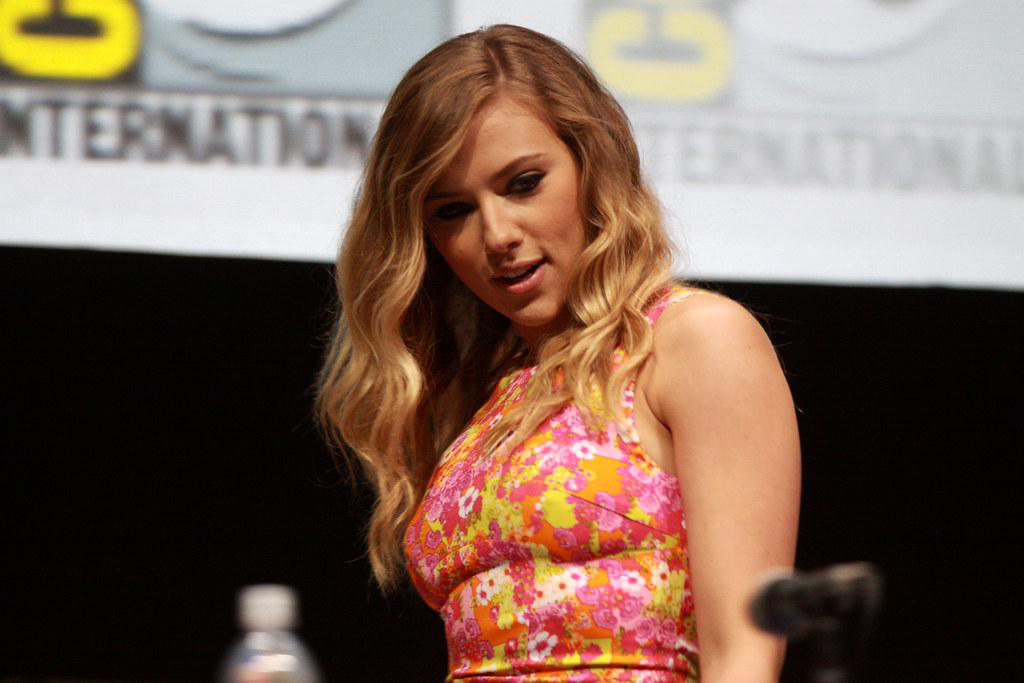

In [ ]:
dataset['train'][14]['image']

Answer a few questions about the dataset you've built:

* Dataset size: How many images are in your dataset? How many different "labels" are there? [ANSWER HERE]
<br> Ans: Images:  18, Labels: 6

* Dataset diversity: How what diversity / representativeness considerations did you take when building your dataset? [ANSWER HERE]
<br> Ans: Different angles, different ages for some celebs, with and without beard, different facial expressions


* **Push the Dataset to the Hugging Face Hub**

Now that you have a dataset, upload it to the Hugging Face Hub so that you can share it with others! Here is some information about uploading datasets to the Hub: https://huggingface.co/docs/datasets/upload_dataset#upload-with-python


In [ ]:
dataset.push_to_hub("celeb-identities")

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Once you've uploaded your dataset, you should be able to preview the dataset, and see the number of samples and the labels of the each sample!

What is the URL to your dataset: [ANSWER HERE]
<br> Ans: https://huggingface.co/datasets/Ashish08/celeb-identities

Please make sure that the dataset is **public**

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Ashish08/celeb-identities", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/18 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Ashish08___parquet/Ashish08--celeb-identities-555d0919f6b61926/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [ ]:
for image in dataset['image']:
  print(image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x334 at 0x7F17B1FC3790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=370x500 at 0x7F1785732140>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=326x500 at 0x7F1785730310>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=683x1024 at 0x7F17857320B0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024 at 0x7F1785730B20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=341x500 at 0x7F1785732410>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x7F1785733C10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7F17857307C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7F1785730490>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=679x1023 at 0x7F17857304F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7F1785731210>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x334 at 0x7F1785732E00>
<PIL.Jpe

In [ ]:
dataset['label']

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]

# Step 3: Evaluating the Embedding Models on your Dataset

Now, let's evaluate each of the models on the dataset you've built. For this example, we will evaluate how good the embeddings from the same celebrity. "cluster" together.

So we now have to decide on a *metric* we will use to measure the performance for our machine learning models. There are many different metrics that allow you to assess the quality of clustering results. We will use the silhouette score (SS). This measure has a range of [-1, 1] and is calculated using the mean intra-cluster distance ($a$) and the mean nearest-cluster distance ($b$) for each sample. The SS for a _single sample_ is $(b - a) / \text{max}(a, b)$, where $b$ is the distance between a sample and the nearest cluster that the sample is not a part of.

![](https://uploads-ssl.webflow.com/5f5148a709e16c7d368ea080/5f7dea907b8e8c7769e769c8_5f7c9650bc3b1ed0ad2247eb_silhouette_formula.jpg)

We then take the average of value of the SS across all samples to get a single SS for our entire dataset.

In this case, we will be using the `sklearn.metrics.silhouette_score` function which takes in two required parameters: (1) a matrix consisting of the embeddings of a list of samples and (2) a list of labels.

Using each of these models:
* https://huggingface.co/sentence-transformers/clip-ViT-B-16
* https://huggingface.co/sentence-transformers/clip-ViT-B-32
* https://huggingface.co/sentence-transformers/clip-ViT-L-14

create embeddings for all of the training images of the celebrities. And then compute the SS metric for all of the embeddings. Also record the running time for computing the embeddings for each model.


In [ ]:
# Load all of the models

models = [
    "sentence-transformers/clip-ViT-B-16",
    "sentence-transformers/clip-ViT-B-32",
    "sentence-transformers/clip-ViT-L-14"
]

In [ ]:
import time
from sklearn.metrics import silhouette_score


for model_name in models:
  # ANSWER HERE
  current_model = SentenceTransformer(model_name)
  print(f"MODEL NAME -> \033[34m{model_name[-13:]}\033[0m")
  start = time.perf_counter()
  img_emb = current_model.encode(dataset['image'], convert_to_tensor=True, show_progress_bar=True).cpu()
  end = time.perf_counter()
  time_taken = end - start
  print(f"Time Taken by Model -> {model_name[-13:]} to create embeddings is \033[35m{time_taken:.3f}\033[0m seconds")
  score = silhouette_score(img_emb, dataset['label'])
  print(f"Silhoutte score: \033[31m{score:.3f}\033[0m")
  print()
  print(70 * '#')
  print()

MODEL NAME -> clip-ViT-B-16


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Time Taken by Model -> clip-ViT-B-16 to create embeddings is 0.715 seconds
Silhoutte score: 0.092

######################################################################

MODEL NAME -> clip-ViT-B-32


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Time Taken by Model -> clip-ViT-B-32 to create embeddings is 0.541 seconds
Silhoutte score: 0.047

######################################################################

MODEL NAME -> clip-ViT-L-14


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Time Taken by Model -> clip-ViT-L-14 to create embeddings is 1.641 seconds
Silhoutte score: 0.136

######################################################################



What SS and running time do you get with each model? [ANSWER HERE]

<mark>The SS and running time are mentioned above.</mark>

If you had to pick one model to use for facial identity recognition, which one would it be? Why?

[ANSWER HERE]

<mark>clip-Vit-L-14 is better in terms of silhouette score and embeddings are created under 2s so it is reasonable, it is important for us unlock the phone for the right owner and we can tolerate a small tradeoff in terms of time taken.</mark>

# Step 4: Choosing a Distance Threshold

In order to use this model for facial identity recognition, we need to choose a _similarity threshold_. If two faces are similar enough to each other (above this threshold), we will quantify them as being from the same person. If they are below this threshold, we will quantify them as different. Using the model you identified in the previous part, let's first compute the average distance between each pair of embeddings, as well as the average distance between each pair of embeddings of images that belong to the same celebrity.

Again, we'll find *cosine_similarity* quite useful

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer("sentence-transformers/clip-ViT-L-14") # ANSWER HERE
embeddings = model.encode(dataset['image'], show_progress_bar=True) # ANSWER HERE

similarities = cosine_similarity(embeddings) # ANSWER HERE

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

* What is the average cosine similarity between **all images**?

In [ ]:
import numpy as np

print(f"The average cosine similarity between all images -> \033[31m{np.mean(similarities):.3f}\033[0m")

The average cosine similarity between all images -> 0.583


* What is the average cosine similarity between all images of the **same celebrity**?

In [ ]:
import numpy as np

# Group embeddings by similar label
celeb_embeddings = {}
for e, l in zip(embeddings, dataset['label']):
  if l not in celeb_embeddings:
    celeb_embeddings[l] = [e]  # Fixed line
  else:
    celeb_embeddings[l].append(e)

In [ ]:
# Calculate avg similarity for each celebrity
avg_similarity = []
for e in celeb_embeddings.values():
  matrix = cosine_similarity(e)
  similarity = np.mean(matrix)
  avg_similarity.append(similarity)

In [ ]:
print(f"The average cosine similarity between all images of the same celebrity-> \033[31m{np.mean(avg_similarity):.3f}\033[0m")

The average cosine similarity between all images of the same celebrity-> 0.799


Based on the above calculations, what similarity threshold do you pick, and why? [ANSWER HERE]

<br> Ans: <mark> 0.75. Seems to be reasonable right now. Although we need better results. The dataset could be improved.</mark>  

# Step 5: Building a Demo

A high-level metric like accuracy doesn't give us a great idea on how the model will work when presented with new data from the real world. To understand this, we will build a web-based demo that can be used on our phones or computers through a web browser to test our model.

The `gradio` library lets you build web demos of machine learning models with just a few lines code. Learn more about Gradio here: https://gradio.app/getting_started/

Gradio lets you build machine learning demos simply by specifying (1) a prediction function, (2) the input type and (3) the output type of your model. Write a prediction function that takes in two images and returns "SAME PERSON, UNLOCK PHONE" if they are within the distance threshold and "DIFFERENT PEOPLE, DON'T UNLOCK" if they are above the distance threshold

In [ ]:
import matplotlib.pyplot as plt

def predict(im1, im2):
  # ANSWER HERE
  if sim > 0.75:
    return sim, "SAME PERSON, UNLOCK PHONE"
  else:
    return sim, "DIFFERENT PEOPLE, DON'T UNLOCK"

* **Build a Gradio web demo of your image classifier and `launch()` it**

Create a `gradio.Interface` and launch it! In this case, we've provided the Gradio code that you need to launch the demo.

In [ ]:
import gradio as gr

interface = gr.Interface(fn=predict,
                         inputs= [gr.Image(type="pil", source="webcam"),
                                  gr.Image(type="pil", source="webcam")],
                         outputs= [gr.Number(label="Similarity"),
                                   gr.Textbox(label="Message")]
                         )

interface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


## Step 5b: Upload your Demo to Spaces (Optional)

Although we don't require it, we highly recommend that you upload your Gradio app to Hugging Face Spaces as it will allow you to easily share it with others or add it to your machine learning portfolio!

1. Create a new **public** Space with the code for your Gradio app. You might find this tutorial helpful: https://huggingface.co/blog/gradio-spaces (Note that in addition to uploading the code for your Gradio demo, you'll also need to upload the saved model files, as well as a `requirements.txt` file).
1. Once your app launches, please put the link to your Space here:

[ANSWER HERE]



# Step 6: Trying your Model with "Real World" Data!

* **Use the share link (or Space link if you completed 5b) created above to open up your app on your phone**

Now test your model on some real images -- of yourself or your friends. What do you notice about the performance of your model on your own images versus those on the training set?  

[ANSWER HERE]

# Bonus: Extensions

Now that you've worked through the project and have a functioning app, what else can we do to improve our results?

* **Try the recently-released CLIP model from LAION**: Another model that you could try is the [recently-released CLIP model from LAION]()https://huggingface.co/laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K. Unlike the model from OpenAI, this one has been trained on a public dataset, and claims better results. How does it fare in your experiments?
* **Extract faces from images**: One way to dramatically improve the performance of our app would be to do some preprocessing to extract faces. For example, you could use the [SegmentAnything Model (SAM)](https://github.com/facebookresearch/segment-anything) to sesgment faces from an image before it is passed into the image embedding. Can you implement this and see how your embedding results change? Does your Gradio app get better as well?
* **Systematically explore different similarity thresholds**: In step 4, you picked a single similarity threshold. How can you systematically the "best" threshold? One way would be to try various similarity thersholds and then compute the false positive rates (what % of the time two different celebrities would be classified as the same person with this threshold) as well as false negative rates (what % of the time the same celebrity would be classified as two different people with this threshold). We would need to find a threshold that balances a low false negative and a low false positive rate.
* **Try scraping a much larger dataset.** For this project, we manually downloaded a relatively small dataset. We would get more robust results if we were to programmatically scrape a larger dataset. There are many Python libraries that allow you to scrape image libraries (such as [flickrapi](https://gist.github.com/yunjey/14e3a069ad2aa3adf72dee93a53117d6)). Using such libraries, can you build a 10x larger dataset? How do your evaluation results change as a result?
* **Finetune the image embedding model on faces**: We used general-purpose image embedding models as part of this exercise. To improve the performance of our models, we could actually *fine-tune* our embeddings on a dataset of facial images first. Such a [process is described here](https://huggingface.co/blog/how-to-train-sentence-transformers), and if you implement this, you'll notice a marked improvement in the results. Note that this requires building a larger dataset, so if you are interested in doing this extension, do the the previous extension as well!



---


#### This project is from [Abubakar Abid's](https://twitter.com/abidlabs) course: *Building Computer Vision Applications* on CoRise. Learn more about the course [here](https://corise.com/course/vision-applications).